**AST4310, Autumn 2020, Julia version**

# Project 3: "La Palma": Anatomy of a sunspot


#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended julia imports to solve the exercises.

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});"""

In [2]:
using Unitful
using UnitfulRecipes   # To make unitful play with plots, otherwise need to ustrip(temp)
using Plots
import FITSIO  # To read FITS files

## 1. Background

### 1.1 La Palma

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Swedish_Solar_Telescope.jpg/321px-Swedish_Solar_Telescope.jpg" alt="SST">

Atop the volcano in the island of La Palma (Canary Islands) sits the [Roque de Los Muchachos Observatory](https://en.wikipedia.org/wiki/Roque_de_los_Muchachos_Observatory),  one of the world's largest astronomical observatories. Among others, it hosts the largest single aperture optical telescope in the world ([GranTeCan](https://en.wikipedia.org/wiki/Gran_Telescopio_Canarias)), the [Nordic Optical Telescope](https://en.wikipedia.org/wiki/Nordic_Optical_Telescope) and the [Swedish 1-m Solar Telescope](https://en.wikipedia.org/wiki/Swedish_Solar_Telescope) (SST). The SST has a modest size compared to night-time optical telescopes, but it compensates with highly advanced instrumentation that enable it to consistently observe at its diffraction limit with a truly astronomical data rate (Gigabytes per second). While not the largest solar telescope around, the SST is arguably still the most prolific solar observatory and has produced the most detailed views into the solar atmosphere.

In this project, you will make use of detailed spectral observations from the SST to solve an age-old mystery that is still not completely understood: what is a sunspot and what are its properties? You will follow the steps of early astronomers who asked this question, starting with [George Ellery Hale](https://en.wikipedia.org/wiki/George_Ellery_Hale), who first linked sunspots and magnetic fields in 1908. You will do it in an accelerated fashion, because unlike early astronomers you will not be limited by low-resolution instruments. Instead, you will make use of rich SST observations whose level of detail would be unthinkable just a few decades ago. But first, let's recap how we can use spectra to get information about the atmosphere of a star.

### 1.2 Spectral Diagnostics

In Project 2, you calculated spectral lines from an isothermal layer and saw how the shapes and strengths of lines changed based on different properties (e.g. parameters of the Voigt function, and temperature of the surface and reversing layer). In this project, we will work from an observational perspective: we use the spectra to determine the parameters of the atmosphere.

#### 1.2.1 Brightness temperature

The brightness temperature $T_\mathrm{b}$ is defined as the temperature that needs to be put into the Planck function $B_\nu$ such that it radiates as much as the observed intensity (at a given wavelength/frequency):

$$
B_\nu(T_\mathrm{b}) = I_\nu^\mathrm{obs}.
$$

It can be obtained by inverting the Planck function in the above equation, solving for $T_\mathrm{b}$. If a body radiates as a black body, then $I_\nu \propto B_\nu$, and $T_\mathrm{b}$ is the same for all frequencies. Otherwise, $T_\mathrm{b}$ is frequency-dependent. Many stellar spectra have the shape of a Planck function, with a few spectral lines sprinkled in. This means that brightness temperatures from frequencies away from the centres of lines (so called "continuum") are more likely to be close to the effective temperature of the star.



#### 1.2.2 Velocities

So far, we have assumed that the region where spectral lines are formed is not moving. The individual atoms and electrons are moving by virtue of their temperature, but the region as a whole does not have a macroscopic velocity. This is not true generally, and most astrophysical bodies have significant large-scale movements. Radiation from a moving body is going to be shifted according to the Doppler effect:

\begin{equation}
\frac{\lambda_0 -  \lambda}{\lambda_0} = \frac{\Delta\lambda}{\lambda_0} = \frac{v}{c},
\end{equation}

where $\lambda_0$ is the rest wavelength, $\lambda$ the observed Doppler-shifted wavelength, and $v$ the velocity of the body. Spectral lines are also Doppler shifted, and this is one of their most powerful uses: their $\Delta\lambda$ shifts can be used to measure the velocities of distant bodies according to equation (1). Using this definition, a positive $v$ means a blue-shift (meaning the body is moving towards us), and a negative $v$ means a red-shift (moving away from us). The only catch is that velocities measured from the Doppler effect are not the full velocity vector, but only the component in the axis towards the observer (line of sight), so they are:

$$
v_\mathrm{los} = v \cos\theta,
$$
where $\cos\theta\equiv\mu$, and $\theta$ the angle from the normal of the emitting surface.

#### 1.2.3 Line widths

The widths of spectral lines are another powerful diagnostic tool. Several different factors can affect the widths or broadening of lines, with the natural broadening and Doppler broadening among the most important. However, in sunspots the widths of spectral lines are dominated by the [Zeeman effect](https://en.wikipedia.org/wiki/Zeeman_effect). For magnetically-sensitive lines, the presence of magnetic fields will split the atomic level energies. This split in effect causes one spectral line to become instead two (or more) lines, and their separation $\Delta\lambda_B$ is given by:

\begin{equation}
\Delta\lambda_B = \frac{e}{4\pi m_e c} \lambda_0^2 B.
\end{equation}

(The above is valid for mksA SI units.)

Typical line properties and magnetic fields in the sun mean that the Zeeman components of a line are not fully split. Instead of appearing as two separated lines, a spectral line appears as one broad line.


#### 1.2.4 Magnetic Fields

For lines that are not fully split by Zeeman effect, one cannot use the intensity profile to directly measure magnetic fields. The observations we will use here fall into this category. However, if we observe not only the intensity $I_\lambda$ but also $V_\lambda$, the circular polarisation of light (also called Stokes V), and are in the so-called *Weak Field Approximation*, we have that 

\begin{equation}
V_\lambda = - \Delta\lambda_B \bar{g} \cos\theta \frac{\partial I_\lambda}{\partial \lambda},
\end{equation}

where $\theta$ is the angle between the line of sight and the magnetic field vector, and $\bar{g}$ the effective Landé factor, a measure of how magnetically-sensitive a line is. Thus, knowing $I_\lambda$ and $V_\lambda$ we can use the two equations above to determine $B\cos\theta$, or $B_\mathrm{los}$, the line of sight component of the magnetic field vector. 

Equation (3) is valid for any wavelength, but in practice not all wavelengths have the same sensivity due to instrumental effects such as noise. Therefore, the following formulation is usually adopted to measure $B_\mathrm{los}$ from observations:

\begin{equation}
B_\mathrm{los} = -\frac{4 \pi m_e c}{e \bar{g} \lambda_0^2}\frac{\sum_\lambda \frac{\partial I}{\partial \lambda} V_\lambda}{\sum_\lambda\left(\frac{\partial I}{\partial \lambda}\right)^2}
\end{equation}


**Note:** strictly speaking, sunspots are not in the regime of the Weak Field Approximation, which is valid when $\Delta\lambda_B \ll \Delta\lambda_D$ . However, for the sake of simplicity, you should assume it is valid here.


### 1.3 An SST Dataset

#### 1.3.1 Overview

We will work with a dataset acquired with the [CRISP](https://dubshen.astro.su.se/wiki/index.php/CRISP) instrument at the SST. CRISP is a Fabry-Pérot interferometer that acquires images at different wavelengths, and can quickly "scan" through spectral lines. These datasets are multi dimensional: there are two dimensions of space (x and y), a dimension of wavelength (e.g. number of points in a spectral line), and a dimension of time. In addition, there can be a fifth dimension: different types of polarisation (reconstructing the [Stokes vector](https://en.wikipedia.org/wiki/Stokes_parameters)). For this exercise we use a single timestep, so there is no time dimension. 

We will use only one spectral line, the Fe I line at 617.334 nm. This line has a lower-level energy of 0.35568 aJ, and an effective Landé factor $\bar{g}$ of 2.499. This line is widely used in studies of solar magnetism, and most famously it was the [line chosen for the HMI instrument](https://arxiv.org/pdf/astro-ph/0608124.pdf) on board [SDO](https://sdo.gsfc.nasa.gov/mission/).

This dataset is state of the art; its spatial resolution is one of the highest available today. It was acquired recently: on the 7th of August 2020. The target was the central sunspot of [NOAA Active Region 12770](https://solarmonitor.org/index.php?date=20200807&region=12770). The data were reduced by and are provided courtesy of Jayant Joshi and Luc Rouppe van der Voort.

The dataset is not included in this repository, you must [dowload it](https://www.uio.no/studier/emner/matnat/astro/AST4310/h20/data/sst_sunspot_617_2020.08.07.fits) (93 MB). The format is a special type of FITS filw written by astropy's QTable, a type of table with units. Once you saved it in the current directory, you can open it with:

In [3]:
"""
    read_qtable_fits(filename)

Reads a FITS file produced by astropy.QTable into a dictionary
"""
function read_qtable_fits(filename)
    fobj = FITSIO.FITS(filename)
    header = FITSIO.read_header(fobj[2])
    nvars = header["TFIELDS"]
    data = Dict()
    for i=1:nvars
        name = header["TTYPE$(i)"]
        unit = header["TUNIT$(i)"]
        # Convert unit to a format that Unitful understands
        unit = replace(unit, r" " => " * ")
        unit = replace(unit, r"\-" => "^-")
        data[Symbol(name)] = read(fobj[2], name) .* uparse(unit)
    end
    if haskey(header, "DATE") 
        data[:meta] = Dict(:date => header["DATE"])
    end
    return data
end

read_qtable_fits

In [4]:
data = read_qtable_fits("SST_sunspot_617_2020.08.07.fits")

Dict{Any,Any} with 4 entries:
  :wavelength => Quantity{Float64,𝐋,Unitful.FreeUnits{(nm,),𝐋,nothing}}[617.268…
  :intensity  => Quantity{Float32,𝐌 𝐓⁻²,Unitful.FreeUnits{(Hz⁻¹, m⁻², sr⁻¹, W),…
  :meta       => Dict(:date=>"2020-08-07 08:31:05.591")
  :stokes_v   => Quantity{Float32,𝐌 𝐓⁻²,Unitful.FreeUnits{(Hz⁻¹, m⁻², sr⁻¹, W),…

It has three variables: intensity, Stokes V (circular polarisation), and wavelength. There are 13 wavelengths, roughly covering the Fe I 617 nm line profile. The intensity has three dimensions: (nx, ny, wavelength). With `nx=974` and `ny=961`, the dataset contains almost one million spectra. The size of each spatial pixel is approximately 0.058 arcseconds, or 42.46 km on the solar surface. We can plot an image at the first wavelength point (far wings of the line, close to continuum) with:

In [5]:
heatmap(data[:intensity][:, :, 1] .|> u"nW / m^2 / sr / Hz", seriescolor=:inferno, 
        aspect_ratio=:equal, xlim=[0, 974], clim=(3, 46), size=(700, 600))

We can see the solar granulation pattern, a sign of the the bubbling convection, and a much darker sunspot in the middle. A sunspot has two regions: the dark **umbra**, and the surrounding **penumbra**. In a sunspot the surface convection is inhibited, and therefore it is significantly cooler and darker because not as much radiation is transported to the surface. Near the right side of the image there are a few dark spots. They are not sunspots, but pores. They are nearly as dark as the umbra, but show no penumbra. 

We can also see an image of Stokes V. Here at a wavelength with maximum polarisation, it is very different from the intensity:

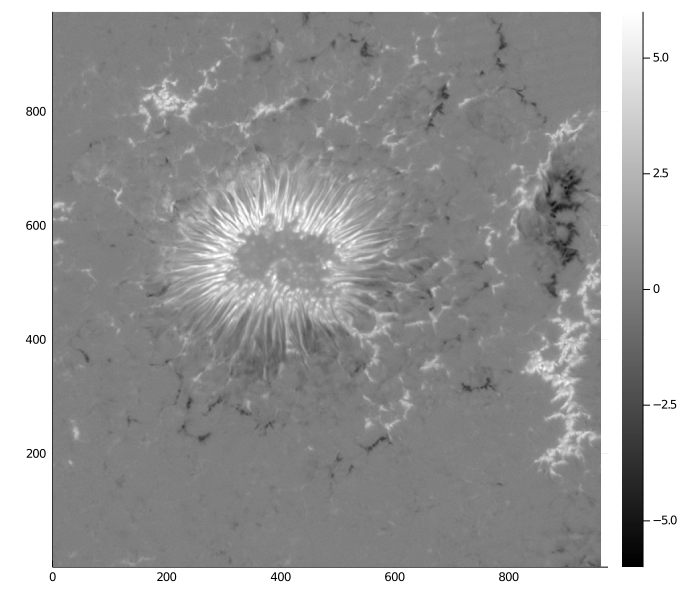

In [6]:
heatmap(data[:stokes_v][:, :, 5] .|> u"nW / m^2 / sr / Hz", seriescolor=:gist_gray, 
        aspect_ratio=:equal, xlim=[0, 974], clim=(-6, 6), size=(700, 600))

We can also plot individual spectra at specific (x, y) points, for example in the granulation and in the sunspot's umbra:

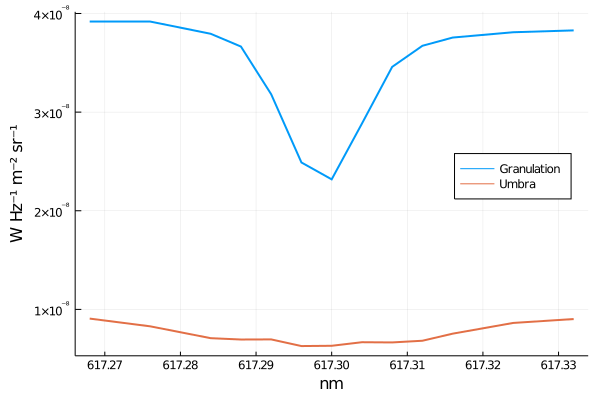

In [7]:
wavelength = data[:wavelength]
plot(wavelength, data[:intensity][200, 200, :], label="Granulation", w=2)
plot!(wavelength, data[:intensity][550, 400, :], label="Umbra", w=2, legend=:right)

You can see that the spectral resolution is relatively coarse: for the sake of fast cadence, the line was only observed at 13 wavelengths.

#### 1.3.2 Data Analysis in Practice

**Line properties.** To measure properties such as velocities and widths of a line, one option is to fit a function (e.g. a Gaussian is often approximate enough). Since this line is in absorption, you would have to fit an inverted Gaussian, which is cumbersome and numerically unstable. Much better is to instead invert the profiles:

$$
I_\mathrm{inv} = I_0 - I_\lambda,
$$
where $I_0$ is the continuum intensity (e.g. the first or last wavelength).

When we approximate the spectra by a Gaussian, the velocity shift is how much the Gaussian in shifted in the wavelength axis. In other words, it is $\mu$, the mean of the distribution. Similarly, the width of the line, which can also be defined as the Full Width at Half Maximum (FWHM) can be related to $\sigma$, the standard deviation of the Gaussian: FWHM$=2\sqrt{2\ln 2}\sigma$.

If you look carefully at individual spectra, you will see that many have a shape that is not very Gaussian. Still, it is ok to fit a Gaussian: the point here is to get a statistical sense, and not a perfect fit every time (with one million spectra, you can't really afford to do that). Besides, even if the line is not Gaussian, the fit would still give you a rough measurement of the Gaussian velocity shift and width.

Other than fitting a function, a simpler option that is also robust in the statistical sense is to take the moments of the distribution (in this case, of the spectra). The first moment $E[X]$ is the mean $\mu$ (i.e., velocity shift), and the second moment $E[(X-\mu)^2]$ is the variance ($\sigma^2$). To take the moments from spectra you need to normalise them, so the expressions become:

\begin{eqnarray}
E[X] = & \mu = &\frac{\int \lambda I_\lambda \mathrm{d}\lambda}{\int I_\lambda \mathrm{d}\lambda} \\
E[(X-\mu)^2] = & \sigma^2 = &\frac{\int (\lambda -\mu)^2 I_\lambda \mathrm{d}\lambda}{\int I_\lambda \mathrm{d}\lambda}.
\end{eqnarray}

Note that you also need to invert the profiles to take the moments in this way.

**Image analysis.** When dealing with rich images showing a lot of information, it is often burdensome to compare images side by side. A powerful technique, useful when the images have exactly the same field of view, is to *blink* them, letting your eyes highlight similarities and differences. You can do this with `@animate` from `Plots`. For example, to blink between the continuum intensity and the intensity in the line centre:

Plots.AnimatedGif("/Users/tiago/Documents/teaching/AST4310/h20/projects/project3/anim.gif")
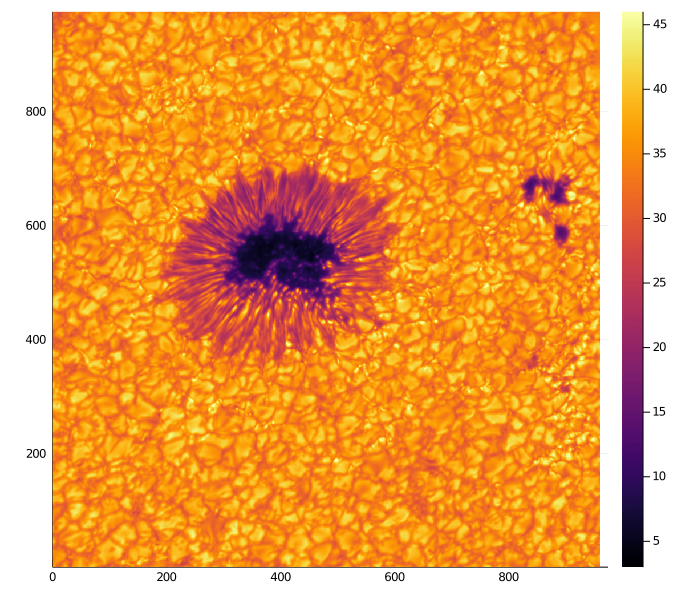

In [49]:
anim = @animate for i=1:2
    if i == 1
        heatmap(data[:intensity][:, :, i*3] .|> u"nW / m^2 / sr / Hz", seriescolor=:inferno, 
        aspect_ratio=:equal, xlim=[0, 974], clim=(3, 46), size=(700, 600))
    else
        heatmap(data[:stokes_v][:, :, 5] .|> u"nW / m^2 / sr / Hz", seriescolor=:gist_gray, 
        aspect_ratio=:equal, xlim=[0, 974], clim=(-6, 6), size=(700, 600))
    end
end 

gif(anim, "anim.gif", fps=1)

If you want to add multiple maps (e.g. velocity shift, width, etc.), just add more in the for loop.

---

### Exercise 1: Anatomy of a sunspot

There is only one exercise in this project. You should answer the question points not in order but in a coherent essay, having a narrative interspersed with code when necessary. This is a project of exploration. You will need to explore the data on your own, using the concepts, knowledge, and terminology you have acquired so far in AST4310. This will involve experimenting on how to best measure properties from spectra, how to visualise them, and discussing their physical meaning.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Imagine you are one of the pioneers observing sunspots for the first time and know nothing about their properties. Your task is to analyse the SST dataset using the spectral diagnostics listed above. In your essay, you should report your findings to an audience of your peers who are similarly ignorant about sunspots, but knowledgeable about spectral analysis (so you don't need to explain what spectral lines are or what we can learn from them). You should answer the following questions:
    
- Using spectral velocities and brightness temperatures, what can you tell about the dynamics of the solar granulation? Which is cooler: the granules or the inter-granular lanes? How are they moving in relation to us?
- In terms of spectral properties, what sets a sunspot apart from the neigbouring granulation?
- Do pores share the same spectral properties of sunspots? Are the two connected?
- Where in a sunspot do you find the largest velocities? And the strongest magnetic fields?
- How much colder are sunspots than the solar granulation? Why are they dark?
- How does the size of this sunspot compare with planet Earth?
    
</div>

Hints:

- You should use the Stokes V data only to determine magnetic field. Spectral analysis of Stokes V profiles is outside the scope of this project, and better left to a more advanced course.
- Velocities should be measured in km/s, converting from $\Delta\lambda$ in nm using the eq. (1).
- Widths of lines are measured in nm, but most commonly they are converted to km/s also using eq. (1), so that they can be better compared to velocities. 
- The centre of the image, in Helioprojective cartesian coordinates, is (x, y) = (-473", 248"). (In these coordinates, the solar disk centre is at (0, 0); the solar radius is about 948".) This means that we are not looking at the sunspot right from the top, but at a slight inclination. This will have some effect on velocities derived from Doppler effect, since we only probe the line-of-sight component.
- To compare individual spectral shapes from different regions (e.g. granules vs umbra) it is best to plot normalised spectra.